In [5]:
# Autoreload 
%load_ext autoreload
%autoreload 2

device = 'cuda'

In [4]:
import torch 
import matplotlib.pyplot as plt

# Elemental Mapping

An element map is an image showing the spatial distribution of elements in a sample. Because it is acquired from a polished section, it is a 2D section through the unknown sample. Element maps are extremely useful for displaying element distributions in textural context, particularly for showing compositional zonation.

### Fully Connected Model

In [4]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

In [5]:
training_images = ['gogo', 'dionisios', 'fanourios', 'odigitria', 'minos']
test_images = ['saintjohn']

In [6]:
band_range = (80, 2128)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=training_images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(80, 2128), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [7]:
# Define the Fully Connected Model
from Elemental_Mapping.models.FullyConnectedModel import FullyConnectedModel

in_features = band_range[1]-band_range[0]
out_features = len(dataset.target_elems)
fcn = FullyConnectedModel(in_features=in_features, out_features=out_features, hidden_dims=[1024, 512, 256, 64])
fcn.to(device)

FullyConnectedModel(
  (layers): ModuleList(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [8]:
# Define Criterion and optimizer
from Elemental_Mapping.loss_functions.AdaptiveL1Loss import AdaptiveL1Loss
import torch.optim as optim
    
criterion = AdaptiveL1Loss()
fcn_optimizer = optim.Adam(fcn.parameters(), lr=0.001, weight_decay=1e-4)

In [ ]:
num_epochs = 1000

for epoch in range(num_epochs):
    train_loss = fcn.train(train_loader, fcn_optimizer, criterion, epochs=1, device=device)
    val_loss, pred = fcn.eval(val_loader, criterion, device=device)
    print(f'Epoch: {epoch}, Train Loss: {round(train_loss, 4)}, Val Loss: {round(val_loss, 4)}')
    # Save model 
    torch.save(fcn.state_dict(), f'./results/Elemental_Mapping/fcn_{fcn.hidden_dims}_best.pt')

In [10]:
# Load state dict
fcn.load_state_dict(torch.load(f'./results/Elemental_Mapping/fcn_{fcn.hidden_dims}_best.pt'))

<All keys matched successfully>

In [11]:
testset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=test_images,
    sample_step = 1,
    device='cuda',
    band_range=(80, 2128),
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [12]:
from utils import open_target_image
real = open_target_image(f'/home/igeor/MSC-THESIS/data/h5/elem_maps/{test_images[0]}.dat')
h, w, _ = real.shape
real = torch.tensor(real).to(device)

In [13]:
# Estimate the elemental map
score, pred = fcn.eval(test_loader, criterion, device=device)
pred = pred.reshape(h, w, len(testset.target_elems))
print(f'Loss: {round(score, 4)}')

Loss: 43.1865


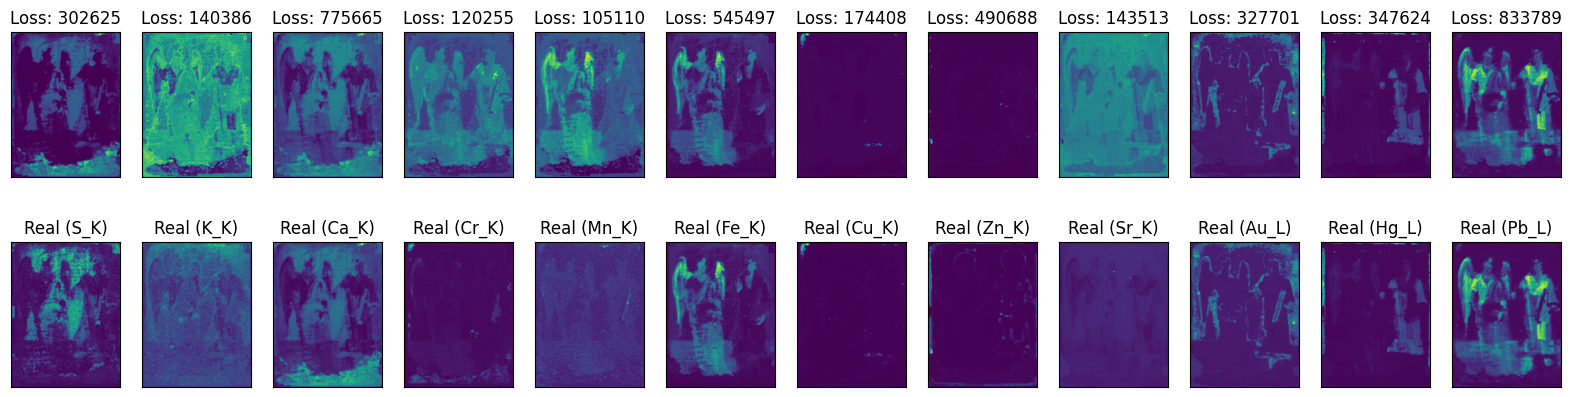

In [23]:
# plot all 12 real and pred bands
fig, axs = plt.subplots(2, 12, figsize=(20, 5))
for i in range(12):
    i_pred = pred[:,:,i].cpu().detach()
    i_real = real[:,:,i].cpu().detach()
    
    loss = criterion(i_pred, i_real)
    
    axs[0, i].set_title(f'Loss: {round(loss.item())}')
    axs[1, i].set_title(f'Real ({testset.target_elems[i]})')

    axs[0, i].imshow(i_pred.numpy())
    axs[1, i].imshow(i_real.numpy())

    # set the ticks off
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

##### Explainability

In [151]:
x = torch.cat([train_dataset[i][0] for i in range(len(train_dataset))], dim=0)
x = torch.sum(x, dim=0)
# Compute the dot product of the weight matrix with the input vector
w = fcn.layers[0].weight

Text(0.5, 1.0, 'Weights values for each input feature')

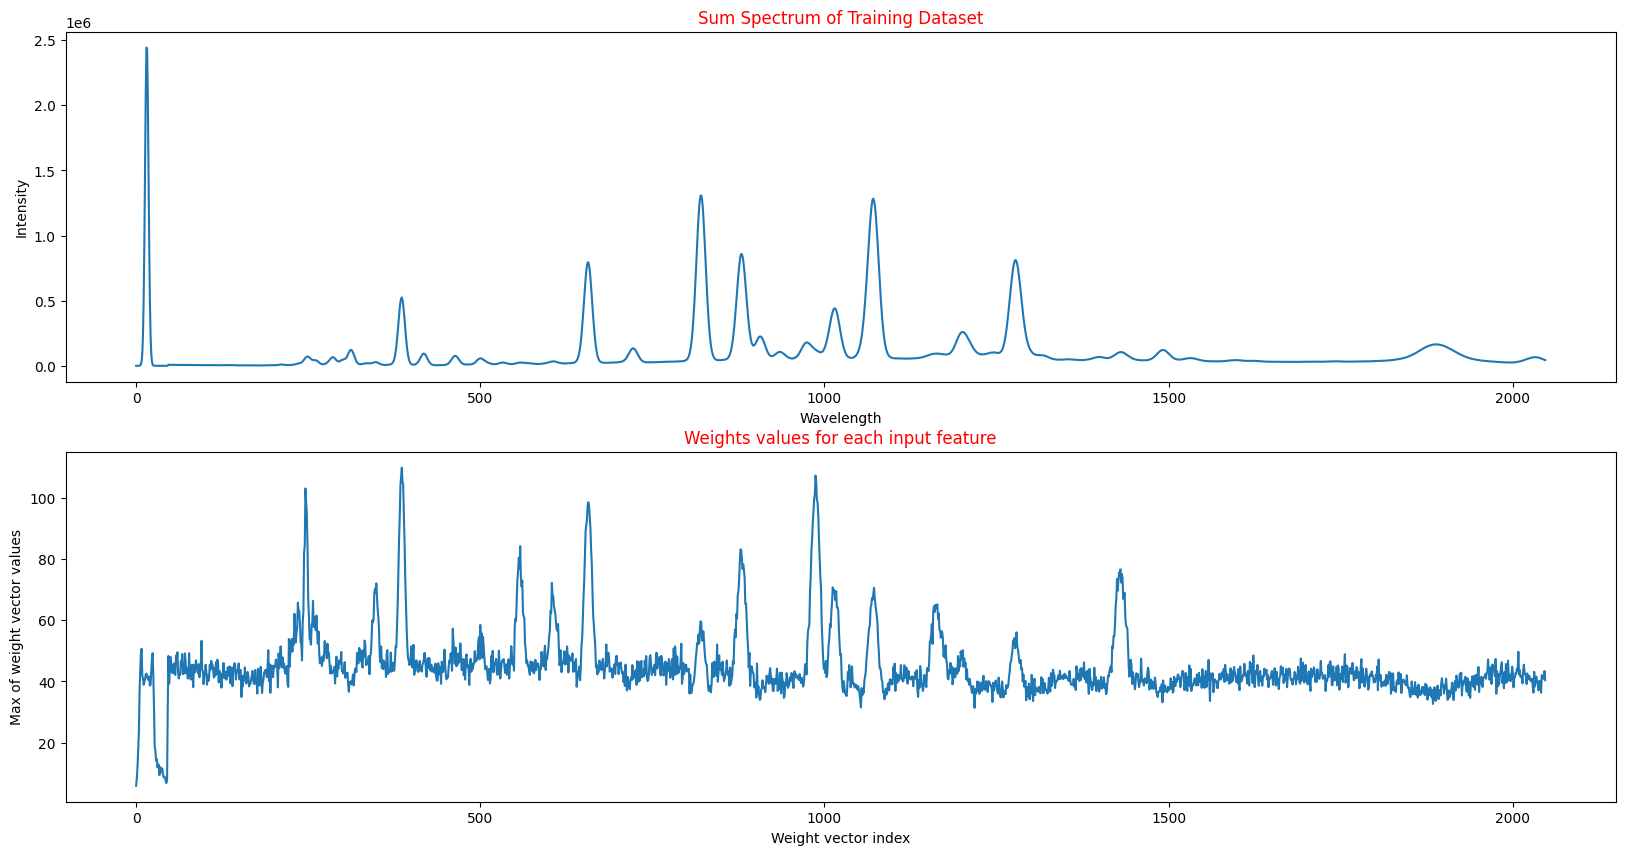

In [155]:
# Compute the maximum value of the weight tensor for each input feature
sum_values = w.sum(dim=0).cpu().detach()
# Find the max value of the weight tensor
max_values = torch.abs(w).max(dim=0)[0].cpu().detach()

fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(x.cpu().detach().numpy())
axs[1].plot(sum_values)

axs[0].set_xlabel('Wavelength')
axs[0].set_ylabel('Intensity')
axs[0].set_title('Sum Spectrum of Training Dataset', color='red')

axs[1].set_xlabel('Weight vector index')
axs[1].set_ylabel('Max of weight vector values')
axs[1].set_title('Weights values for each input feature', color='red')

### 1D Conovolutional Model

In [1]:
from Elemental_Mapping.datasets.Pixel2PixelDataset import Pixel2PixelDataset

In [2]:
training_images = ['gogo', 'dionisios', 'fanourios', 'odigitria', 'minos']
test_images = ['saintjohn']

In [6]:
band_range = (80, 2128)

dataset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=training_images, 
    sample_step = 10, 
    device='cuda', 
    band_range=(80, 2128), 
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [7]:
# Define the Fully Connected Model
from Elemental_Mapping.models.Conv1DModel import Conv1DModel

in_features = band_range[1]-band_range[0]
out_features = len(dataset.target_elems)

cnn1d = Conv1DModel(in_features=in_features, out_features=out_features, hidden_dims=[64, 64])
cnn1d.to(device)

Conv1DModel(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(2,))
  (relu): ReLU()
  (drop): Dropout(p=0.1, inplace=False)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcn): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=12, bias=True)
    (3): ReLU()
  )
)

In [8]:
# Define Criterion and optimizer
from Elemental_Mapping.loss_functions.AdaptiveL1Loss import AdaptiveL1Loss
import torch.optim as optim
    
criterion = AdaptiveL1Loss()
cnn1d_optimizer = optim.Adam(cnn1d.parameters(), lr=0.001, weight_decay=1e-4)

In [156]:
num_epochs = 1000

for epoch in range(num_epochs):
    train_loss = cnn1d.train(train_loader, cnn1d_optimizer, criterion, epochs=1, device=device)
    val_loss, pred = cnn1d.eval(val_loader, criterion, device=device)
    print(f'Epoch: {epoch}, Train Loss: {round(train_loss, 4)}, Val Loss: {round(val_loss, 4)}')
    # Save model 
    torch.save(cnn1d.state_dict(), f'./results/Elemental_Mapping/cnn1d_{cnn1d.hidden_dims}_best.pt')

Epoch: 134, Train Loss: 4.7888, Val Loss: 9.8522
Epoch: 135, Train Loss: 4.7855, Val Loss: 8.0846
Epoch: 136, Train Loss: 4.7906, Val Loss: 10.1108
Epoch: 137, Train Loss: 4.7814, Val Loss: 8.7431
Epoch: 138, Train Loss: 4.7689, Val Loss: 10.3947
Epoch: 139, Train Loss: 4.7866, Val Loss: 9.8066
Epoch: 140, Train Loss: 4.7574, Val Loss: 10.6956
Epoch: 141, Train Loss: 4.786, Val Loss: 9.1719
Epoch: 142, Train Loss: 4.769, Val Loss: 9.4229
Epoch: 143, Train Loss: 4.7781, Val Loss: 9.5286
Epoch: 144, Train Loss: 4.7727, Val Loss: 9.3368
Epoch: 145, Train Loss: 4.7598, Val Loss: 9.8726
Epoch: 146, Train Loss: 4.7498, Val Loss: 9.9818
Epoch: 147, Train Loss: 4.7462, Val Loss: 9.1731
Epoch: 148, Train Loss: 4.7425, Val Loss: 10.964
Epoch: 149, Train Loss: 4.738, Val Loss: 8.8243
Epoch: 150, Train Loss: 4.7569, Val Loss: 11.3292
Epoch: 151, Train Loss: 4.7384, Val Loss: 10.487
Epoch: 152, Train Loss: 4.7347, Val Loss: 9.0567
Epoch: 153, Train Loss: 4.7302, Val Loss: 8.8729
Epoch: 154, Train L

In [9]:
# Load state dict
cnn1d.load_state_dict(torch.load(f'./results/Elemental_Mapping/cnn1d_{cnn1d.hidden_dims}_best.pt'))

<All keys matched successfully>

In [10]:
testset = Pixel2PixelDataset(
    '/home/igeor/MSC-THESIS/data/h5',
    image_names=test_images,
    sample_step = 1,
    device='cuda',
    band_range=(80, 2128),
    target_elems=['S_K','K_K','Ca_K','Cr_K','Mn_K','Fe_K','Cu_K','Zn_K','Sr_K','Au_L','Hg_L','Pb_L'])

test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

In [11]:
from utils import open_target_image
real = open_target_image(f'/home/igeor/MSC-THESIS/data/h5/elem_maps/{test_images[0]}.dat')
h, w, _ = real.shape
real = torch.tensor(real).to(device)

In [12]:
# Estimate the elemental map
score, pred = cnn1d.eval(test_loader, criterion, device=device)
pred = pred.reshape(h, w, len(testset.target_elems))
print(f'Loss: {round(score, 4)}')

Loss: 14.8934


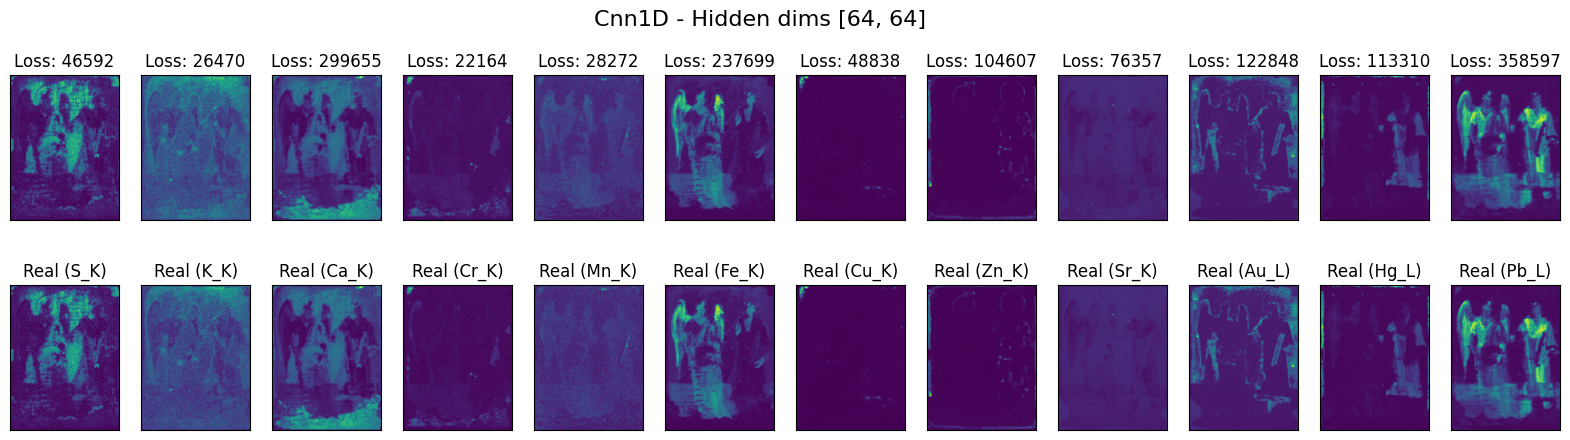

In [13]:
# plot all 12 real and pred bands
fig, axs = plt.subplots(2, 12, figsize=(20, 5))
fig.suptitle('Cnn1D - Hidden dims [64, 64]', fontsize=16)

for i in range(12):
    i_pred = pred[:,:,i].cpu().detach()
    i_real = real[:,:,i].cpu().detach()
    
    loss = criterion(i_pred, i_real)
    
    axs[0, i].set_title(f'Loss: {round(loss.item())}')
    axs[1, i].set_title(f'Real ({testset.target_elems[i]})')

    axs[0, i].imshow(i_pred.numpy())
    axs[1, i].imshow(i_real.numpy())

    # set the ticks off
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])

##### Explainability

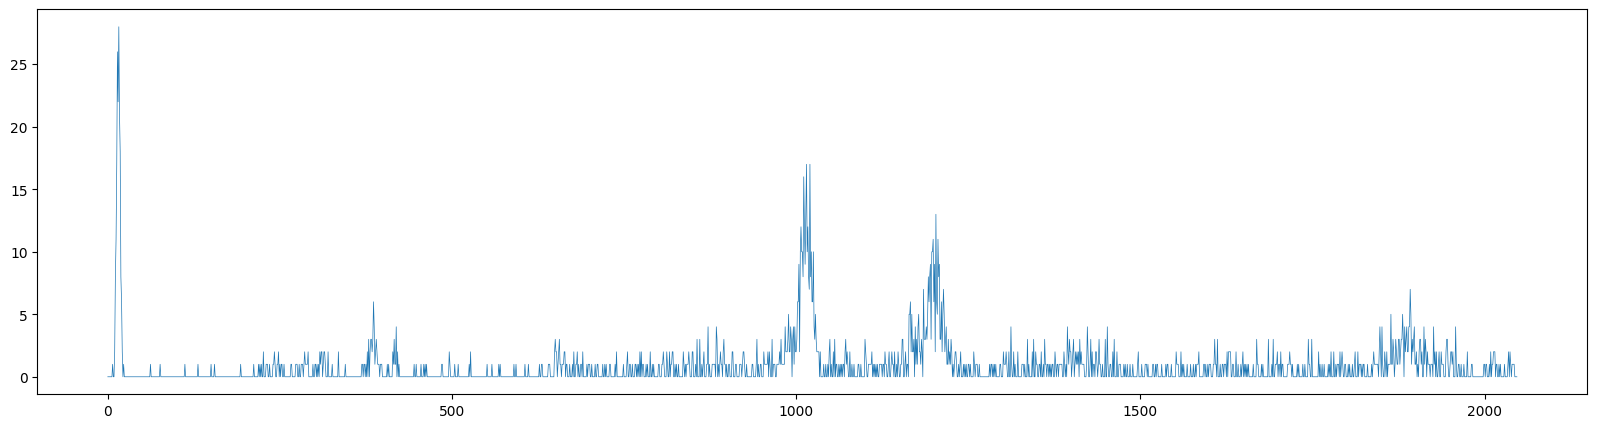

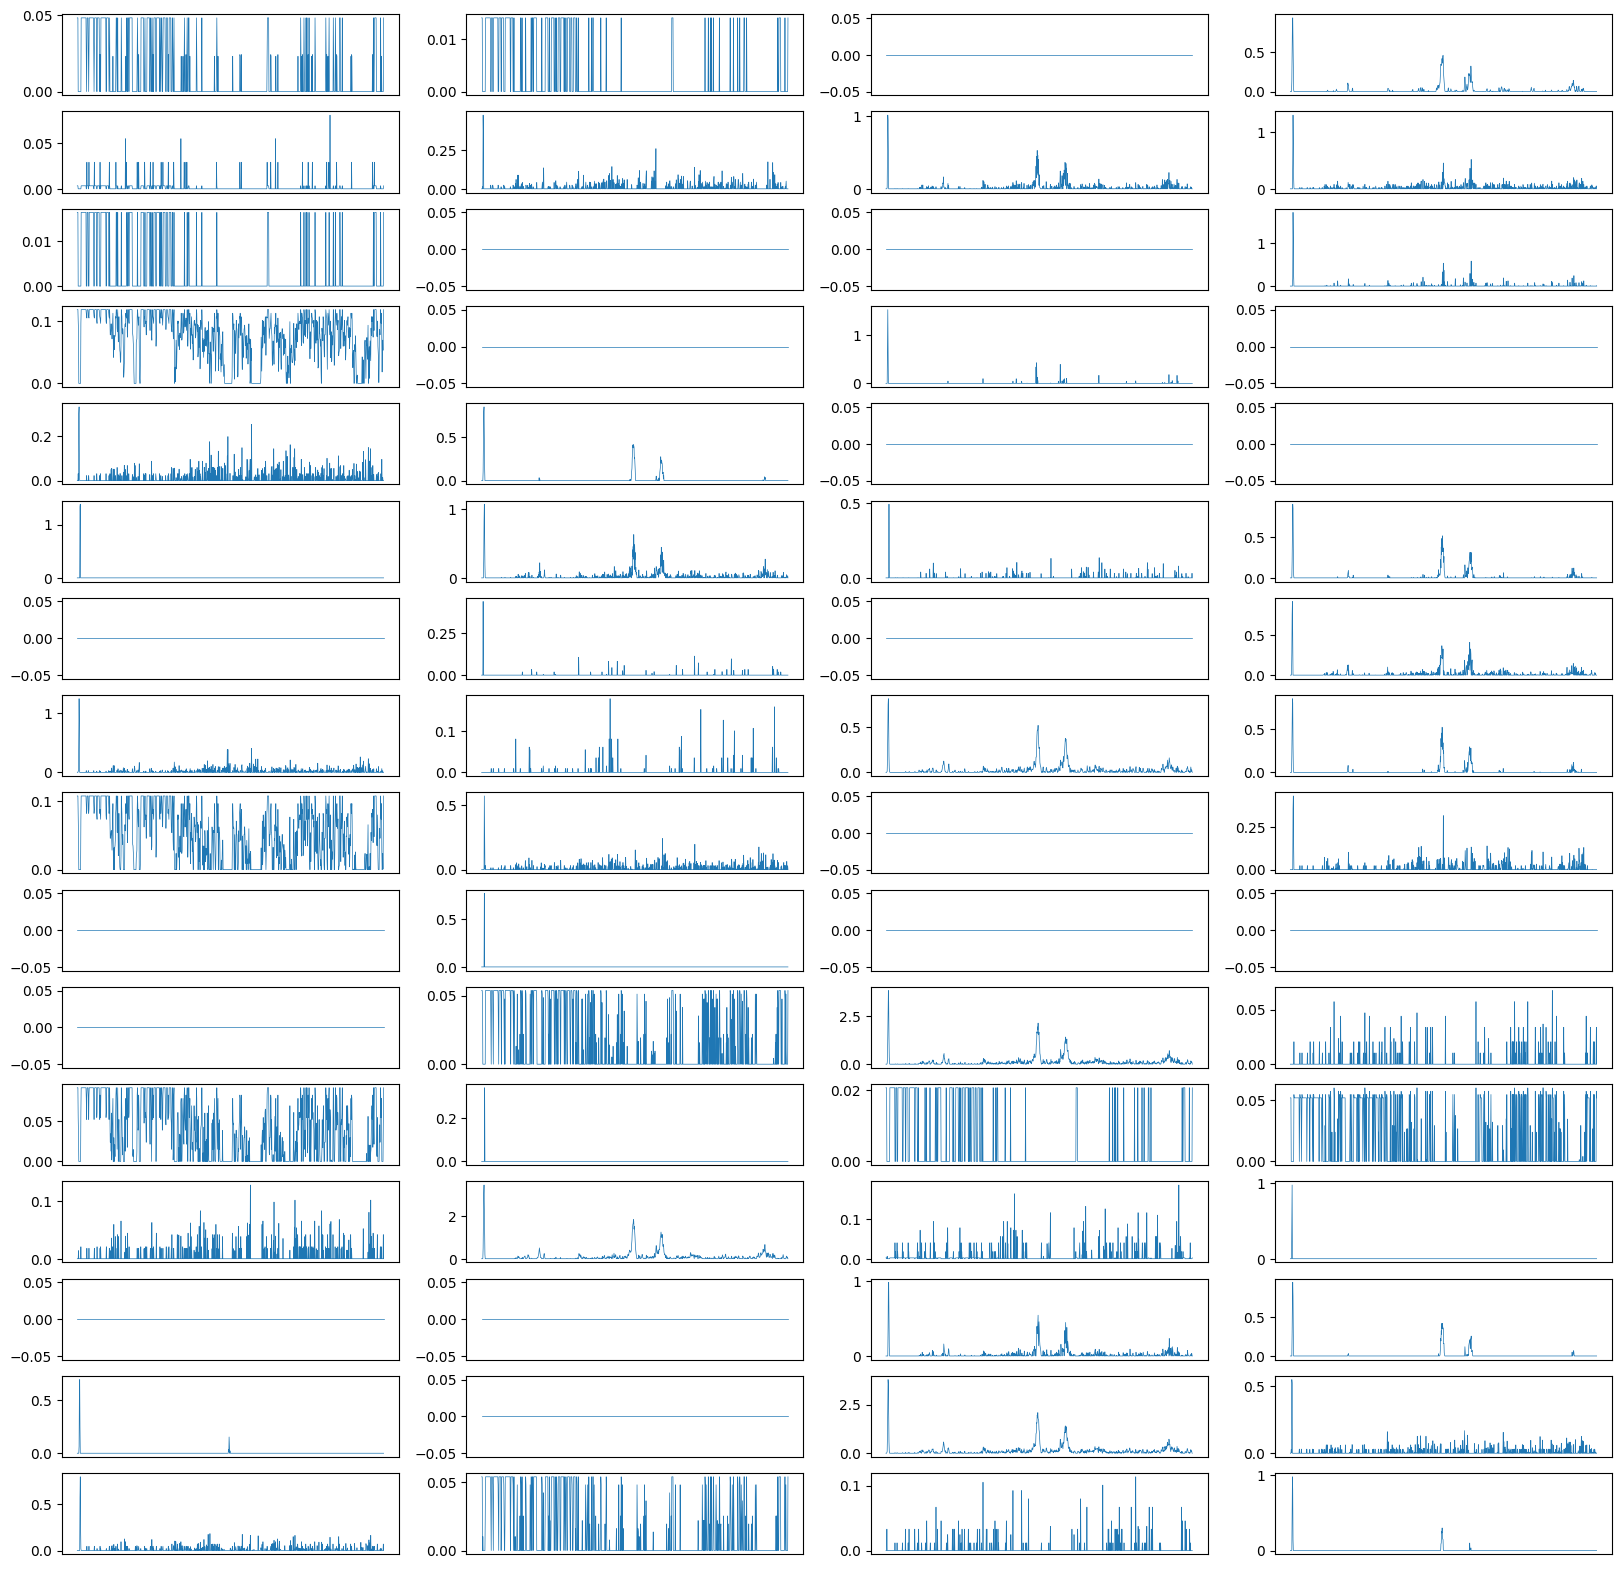

In [36]:
# Display the output features of the first convolutional layer
# Get the first convolutional layer
conv1 = cnn1d.conv1

# Get a random sample from the test set
sample, _ = dataset[1000]

# Feed the sample to the network and display the output of the first convolutional layer
cnn1d.set_state('eval')
with torch.no_grad():
    conv1_output = cnn1d.relu(cnn1d.conv1(sample.to(device)))

conv1_output = conv1_output.squeeze().cpu().detach().numpy()

# Plot the input spectra
fig = plt.figure(figsize=(20, 5))
plt.plot(sample.squeeze().cpu().detach().numpy(), linewidth=0.5)

# Plot the output of the first convolutional layer
fig, axs = plt.subplots(16, 4, figsize=(20, 20))
for i in range(16):
    for j in range(4):
        axs[i, j].plot(conv1_output[i*4+j], linewidth=0.5)
        axs[i, j].set_xticks([])
        # axs[i, j].set_yticks([])